In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import matplotlib.pyplot as plt
from dsa_analysis import Simulation, combine_simulations, visualize, load_config
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity


%load_ext autoreload
%autoreload 2

## Parameters

We simulate with $num\_samples$ possible initializations accross $num\_steps$ 

Parameters to compute the dissimilarity matrices and the Procrustes Alignment over Vector Fields, according to [1]

In [2]:
config = load_config('../config.yaml')

# Define parameters
dt = config['simulations']['dt']
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']
perturbation_scale = config['simulations']['perturbations']
orders = config['simulations']['order']

## Similarity vs epochs

We here want to analyse the evolution of the dissimilarity as a function of the epochs

### basic network geometries

Here are the basic patterns

In [3]:
simulation_curve = Simulation(num_samples, num_steps, dt)
pattern_curve = lorenz_parameters['one_attractor'][1]
simulation_curve.simulation_lorenz(pattern_curve)

simulation_two_stable_0 = Simulation(num_samples, num_steps, dt)
pattern_two_stable = lorenz_parameters['two_stable_attractors'][0]
simulation_two_stable_0.simulation_lorenz(pattern_two_stable)

simulation_two_stable_1 = Simulation(num_samples, num_steps, dt)
pattern_two_stable = lorenz_parameters["two_stable_attractors"][1]
simulation_two_stable_1.simulation_lorenz(pattern_two_stable)

simulation_two_stable_2 = Simulation(num_samples, num_steps, dt)
pattern_two_stable = lorenz_parameters["two_stable_attractors"][2]
simulation_two_stable_2.simulation_lorenz(pattern_two_stable)

simulation_two_unstable_0 = Simulation(num_samples, num_steps, dt)
pattern_two_unstable = lorenz_parameters["two_unstable_attractors"][0]
simulation_two_unstable_0.simulation_lorenz(pattern_two_unstable)

simulation_two_unstable_1 = Simulation(num_samples, num_steps, dt)
pattern_two_unstable = lorenz_parameters['two_unstable_attractors'][1]
simulation_two_unstable_1.simulation_lorenz(pattern_two_unstable)

simulation_two_unstable_2 = Simulation(num_samples, num_steps, dt)
pattern_two_unstable = lorenz_parameters["two_unstable_attractors"][2]
simulation_two_unstable_2.simulation_lorenz(pattern_two_unstable)

simulation_straight_line = Simulation(num_samples, num_steps, dt)
simulation_straight_line.simulation_line()

simulations = {
    "staight_line": simulation_straight_line,
    "curve": simulation_curve,
    "two_stable_0": simulation_two_stable_0,
    "two_stable_1": simulation_two_stable_1,
    "two_stable_2": simulation_two_stable_2,
    "two_unstable_0": simulation_two_unstable_0,
    "two_unstable_1": simulation_two_unstable_1,
    "two_unstable_2": simulation_two_unstable_2,
}

In [4]:
combined_simulations = {pattern1:{pattern2:{model:{epoch:None for epoch in ['epoch1','epoch2','epoch3']} for model in ['model1','model2','model3']} for pattern2 in simulations.keys()} for pattern1 in simulations.keys() if pattern1 != 'staight_line'}

We now add some perturbations to these patterns. For each pattern, we create $3$ networks, each simulated over $3$ epochs : 
- Pattern + Noise 1 (the Noise strenght get weaker as we move towards later epochs)
- Pattern + Noise 2 (Different Noise levels, but same trend)
- Pattern + Noise 3 + Curve

In [5]:
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        for model in combined_simulations[pattern1][pattern2]:
            for epoch in combined_simulations[pattern1][pattern2][model]:
                simulations[pattern1].perturbation(
                    perturbation_scale=perturbation_scale[model][epoch],
                    model=model,
                    epoch=epoch,
                )
                combined_simulations[pattern1][pattern2][model][epoch] = simulations[
                    pattern1
                ].perturbations_record[model][epoch]
                if model == 'model3':
                    # add the line attractor
                    mixing_level = 0.3
                    if epoch=='epoch2':
                        mixing_level = 0.15
                    elif epoch == 'epoch3':
                        mixing_level = 0
                    combined = combine_simulations([simulations[pattern2].simulation,simulations[pattern1].perturbations_record[model][epoch]], method='combine',mixing_level=mixing_level)
                    # save it in the simulation
                    combined_simulations[pattern1][pattern2][model][epoch] = combined

In [6]:
combined_simulations

{'curve': {'staight_line': {'model1': {'epoch1': array([[[ 3.52225046e-01,  9.98499855e-01,  7.55445065e-01],
            [ 4.31967099e-01,  9.84930073e-01,  7.22312306e-01],
            [ 4.82724780e-01,  9.74160266e-01,  7.32225021e-01],
            ...,
            [ 2.26475956e-01,  2.24055436e-01, -5.13294845e-04],
            [ 2.23340660e-01,  2.32183333e-01, -8.03338887e-03],
            [ 2.28690237e-01,  2.20719597e-01, -1.63133511e-02]],
    
           [[ 1.00475092e+00,  2.46222732e-01,  2.64961140e-01],
            [ 9.16004359e-01,  2.64539688e-01,  2.62374722e-01],
            [ 8.67443347e-01,  2.60729348e-01,  2.43619628e-01],
            ...,
            [ 1.10022612e-01,  1.12443795e-01, -8.04345023e-03],
            [ 1.16237526e-01,  9.45484014e-02, -1.32879495e-02],
            [ 1.12028924e-01,  1.12432018e-01,  2.58790897e-02]],
    
           [[ 1.35761832e-02,  1.00693799e+00,  6.76247485e-01],
            [ 1.30844559e-01,  9.74728971e-01,  6.48993811e-01],

### Visualization of random network

We here visualize the 3rd network of the pattern $\text {\it{two stable Lorenz attractors}}$

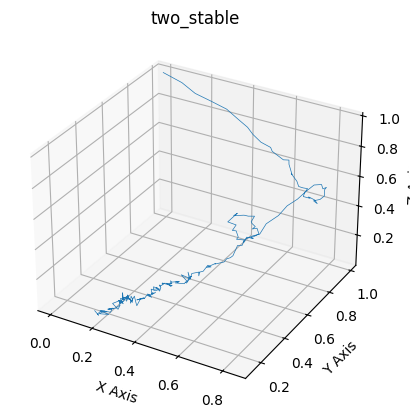

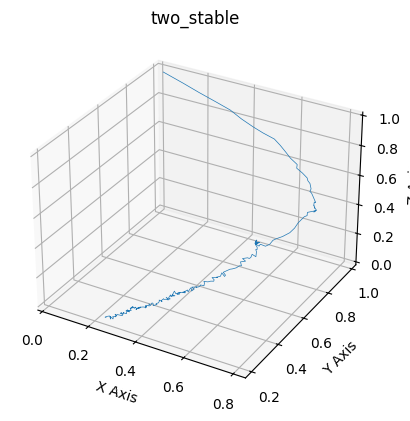

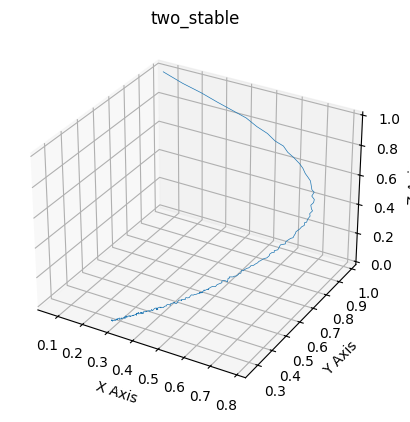

In [7]:
# Visualize the simulations model 1
visualize([combined_simulations["curve"]["two_unstable_2"]["model3"][epoch][100] for epoch in ['epoch1','epoch2','epoch3']], "two_stable")

### We now want to compare the dissimilarity matrices for the 3 networks

In [8]:
# For each attractor, pattern compute the 6 DSA between the 3 models
vectors_dsa = {
    pattern1: {
        pattern2: {"vector1": None, "vector2": None}
        for pattern2 in combined_simulations[pattern1]
    }
    for pattern1 in combined_simulations
}
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        dsa1vs2_epoch1 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model1"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa2vs3_epoch1 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch1"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa1vs2_epoch2 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model1"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa2vs3_epoch2 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch2"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa1vs2_epoch3 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model1"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa2vs3_epoch3 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch3"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        vector_1vs2 = np.array([dsa1vs2_epoch1.fit_score(), dsa1vs2_epoch2.fit_score(), dsa1vs2_epoch3.fit_score()])
        vector_2vs3 = np.array([dsa2vs3_epoch1.fit_score(), dsa2vs3_epoch2.fit_score(), dsa2vs3_epoch3.fit_score()])
        vectors_dsa[pattern1][pattern2]['vector1'] = vector_1vs2
        vectors_dsa[pattern1][pattern2]["vector2"] = vector_2vs3

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAV

In [ ]:
# For each attractor, pattern compute the 6 DSA between the 3 models
# For each attractor, pattern compute the 6 DSA between the 3 models
vectors_pa = {
    pattern1: {
        pattern2: {"vector1": None, "vector2": None}
        for pattern2 in combined_simulations[pattern1]
    }
    for pattern1 in combined_simulations
}
procrustes_measure = similarity.make("measure.sim_metric.cka-angular-score")
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        pa1vs2_epoch1 = procrustes_measure(combined_simulations[pattern1][pattern2]['model1']['epoch1'], combined_simulations[pattern1][pattern2]['model2']['epoch1'])
        pa2vs3_epoch1 = procrustes_measure(combined_simulations[pattern1][pattern2]['model2']['epoch1'], combined_simulations[pattern1][pattern2]['model3']['epoch1'])
        pa1vs2_epoch2 = procrustes_measure(combined_simulations[pattern1][pattern2]['model1']['epoch2'], combined_simulations[pattern1][pattern2]['model2']['epoch2'])
        pa2vs3_epoch2 = procrustes_measure(combined_simulations[pattern1][pattern2]['model2']['epoch2'], combined_simulations[pattern1][pattern2]['model3']['epoch2'])
        pa1vs2_epoch3 = procrustes_measure(combined_simulations[pattern1][pattern2]['model1']['epoch3'], combined_simulations[pattern1][pattern2]['model2']['epoch3'])
        pa2vs3_epoch3 = procrustes_measure(combined_simulations[pattern1][pattern2]['model2']['epoch3'], combined_simulations[pattern1][pattern2]['model3']['epoch3'])
        vector_1vs2 = 1-np.array([pa1vs2_epoch1, pa1vs2_epoch2, pa1vs2_epoch3])
        vector_2vs3 = 1-np.array([pa2vs3_epoch1, pa2vs3_epoch2, pa2vs3_epoch3])
        vectors_pa[pattern1][pattern2]['vector1'] = vector_1vs2
        vectors_pa[pattern1][pattern2]["vector2"] = vector_2vs3

arccos score: 0.9994791251012483 0.0322775502006269 0.0005208748987517442
arccos score: 0.9992773725158701 0.038018798840880115 0.0007226274841298785
arccos score: 0.9998702189539117 0.016111105075202335 0.00012978104608829533
arccos score: 0.999806782399868 0.01965827167510606 0.00019321760013202294
arccos score: 0.9999674522077534 0.0080682053528557 3.254779224659554e-05
arccos score: 0.9999525769677172 0.009738932909874374 4.7423032282778443e-05
arccos score: 0.9994758491475905 0.03237890201443071 0.0005241508524095329
arccos score: 0.8385234442925513 0.5762287275722076 0.16147655570744868
arccos score: 0.9998697559204243 0.01613982075038713 0.00013024407957573647
arccos score: 0.955674709973387 0.29885338152528906 0.04432529002661301
arccos score: 0.9999676513383686 0.008043486313641065 3.2348661631376174e-05
arccos score: 0.9999519407217001 0.009804046435410666 4.805927829987233e-05
arccos score: 0.9994851429116773 0.03209053673674589 0.0005148570883226622
arccos score: 0.69748206

In [ ]:
# For each attractor, pattern compute the 6 DSA between the 3 models
# For each attractor, pattern compute the 6 DSA between the 3 models
vectors_cka = {
    pattern1: {
        pattern2: {"vector1": None, "vector2": None}
        for pattern2 in combined_simulations[pattern1]
    }
    for pattern1 in combined_simulations
}
cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        pa1vs2_epoch1 = cka_measure(
            combined_simulations[pattern1][pattern2]["model1"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
        )
        pa2vs3_epoch1 = cka_measure(
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch1"],
        )
        pa1vs2_epoch2 = cka_measure(
            combined_simulations[pattern1][pattern2]["model1"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
        )
        pa2vs3_epoch2 = cka_measure(
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch2"],
        )
        pa1vs2_epoch3 = cka_measure(
            combined_simulations[pattern1][pattern2]["model1"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
        )
        pa2vs3_epoch3 = cka_measure(
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch3"],
        )
        vector_1vs2 = 1 - np.array([pa1vs2_epoch1, pa1vs2_epoch2, pa1vs2_epoch3])
        vector_2vs3 = 1 - np.array([pa2vs3_epoch1, pa2vs3_epoch2, pa2vs3_epoch3])
        vectors_cka[pattern1][pattern2]["vector1"] = vector_1vs2
        vectors_cka[pattern1][pattern2]["vector2"] = vector_2vs3

arccos score: 0.9994791251012483 0.0322775502006269 0.0005208748987517442
arccos score: 0.9992773725158701 0.038018798840880115 0.0007226274841298785
arccos score: 0.9998702189539117 0.016111105075202335 0.00012978104608829533
arccos score: 0.999806782399868 0.01965827167510606 0.00019321760013202294
arccos score: 0.9999674522077534 0.0080682053528557 3.254779224659554e-05
arccos score: 0.9999525769677172 0.009738932909874374 4.7423032282778443e-05
arccos score: 0.9994758491475905 0.03237890201443071 0.0005241508524095329
arccos score: 0.8385234442925513 0.5762287275722076 0.16147655570744868
arccos score: 0.9998697559204243 0.01613982075038713 0.00013024407957573647
arccos score: 0.955674709973387 0.29885338152528906 0.04432529002661301
arccos score: 0.9999676513383686 0.008043486313641065 3.2348661631376174e-05
arccos score: 0.9999519407217001 0.009804046435410666 4.805927829987233e-05
arccos score: 0.9994851429116773 0.03209053673674589 0.0005148570883226622
arccos score: 0.69748206

In [ ]:
vectors_dsa_averaged = {'vector1':None, 'vector2':None}
vectors_dsa_sd = {'vector1':None, 'vector2':None}
vectors_pa_averaged = {'vector1':None, 'vector2':None}
vectors_pa_sd = {'vector1':None, 'vector2':None}
vectors_cka_averaged = {"vector1": None, "vector2": None}
vectors_cka_sd = {"vector1": None, "vector2": None}
for vector in vectors_dsa_averaged:
    vectors_dsa_averaged[vector] = np.mean([vectors_dsa[pattern1][pattern2][vector] for pattern1 in vectors_dsa for pattern2 in vectors_dsa[pattern1]], axis=0)
    vectors_dsa_sd[vector] = np.std([vectors_dsa[pattern1][pattern2][vector] for pattern1 in vectors_dsa for pattern2 in vectors_dsa[pattern1]], axis=0)
    vectors_pa_averaged[vector] = np.mean(
        [
            vectors_pa[pattern1][pattern2][vector]
            for pattern1 in vectors_pa
            for pattern2 in vectors_pa[pattern1]
        ],
        axis=0,
    )
    vectors_pa_sd[vector] = np.std(
        [
            vectors_pa[pattern1][pattern2][vector]
            for pattern1 in vectors_pa
            for pattern2 in vectors_pa[pattern1]
        ],
        axis=0,
    )
    vectors_cka_averaged[vector] = np.mean(
        [
            vectors_cka[pattern1][pattern2][vector]
            for pattern1 in vectors_cka
            for pattern2 in vectors_cka[pattern1]
        ],
        axis=0,
    )
    vectors_cka_sd[vector] = np.std(
        [
            vectors_cka[pattern1][pattern2][vector]
            for pattern1 in vectors_cka
            for pattern2 in vectors_cka[pattern1]
        ],
        axis=0,
    )

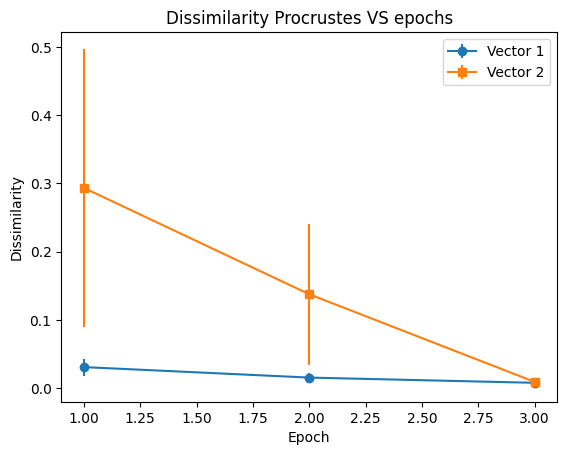

In [ ]:
# Create the plot

# Indices for each component
components = np.array([1, 2, 3])

plt.figure()
plt.errorbar(
    components,
    vectors_pa_averaged["vector1"],
    yerr=vectors_pa_sd["vector1"],
    fmt="-o",
    label="Vector 1",
)  # '-o' creates a line plot with circle markers
plt.errorbar(
    components,
    vectors_pa_averaged["vector2"],
    yerr=vectors_pa_sd["vector2"],
    fmt="-s",
    label="Vector 2",
)  # '-s' creates a line plot with square markers

# Adding title and labels
plt.title("Dissimilarity Procrustes VS epochs")
plt.xlabel("Epoch")
plt.ylabel("Dissimilarity")

# Adding a legend
plt.legend()

# Show the plot
plt.show()

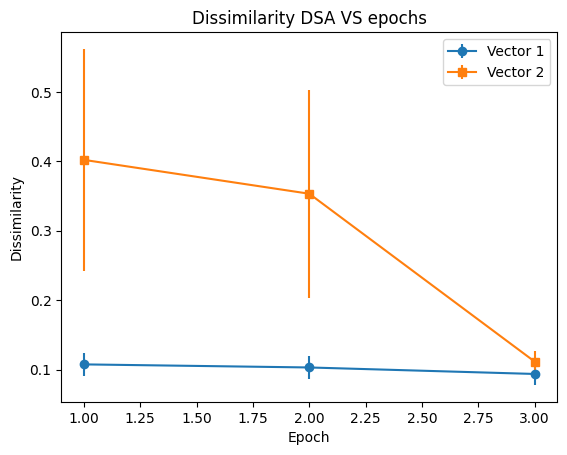

In [ ]:
# Indices for each component
components = np.array([1, 2, 3])

plt.figure()
plt.errorbar(
    components,
    vectors_dsa_averaged["vector1"],
    yerr=vectors_dsa_sd["vector1"],
    fmt="-o",
    label="Vector 1",
)  # '-o' creates a line plot with circle markers
plt.errorbar(
    components,
    vectors_dsa_averaged["vector2"],
    yerr=vectors_dsa_sd["vector2"],
    fmt="-s",
    label="Vector 2",
)  # '-s' creates a line plot with square markers

# Adding title and labels
plt.title("Dissimilarity DSA VS epochs")
plt.xlabel("Epoch")
plt.ylabel("Dissimilarity")

# Adding a legend
plt.legend()

# Show the plot

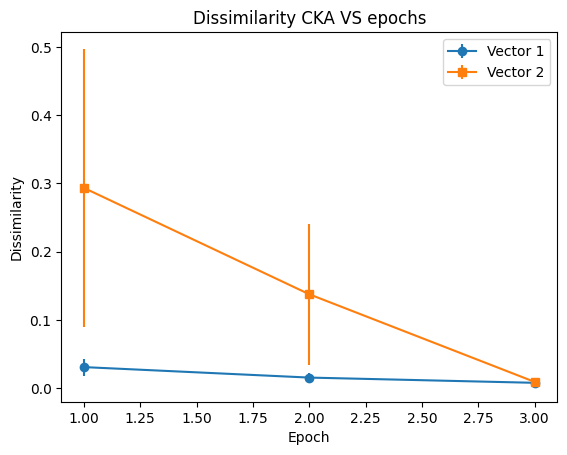

In [ ]:
# Indices for each component
components = np.array([1, 2, 3])

plt.figure()
plt.errorbar(
    components,
    vectors_cka_averaged["vector1"],
    yerr=vectors_cka_sd["vector1"],
    fmt="-o",
    label="Vector 1",
)  # '-o' creates a line plot with circle markers
plt.errorbar(
    components,
    vectors_cka_averaged["vector2"],
    yerr=vectors_cka_sd["vector2"],
    fmt="-s",
    label="Vector 2",
)  # '-s' creates a line plot with square markers

# Adding title and labels
plt.title("Dissimilarity CKA VS epochs")
plt.xlabel("Epoch")
plt.ylabel("Dissimilarity")

# Adding a legend
plt.legend()

# Show the plot

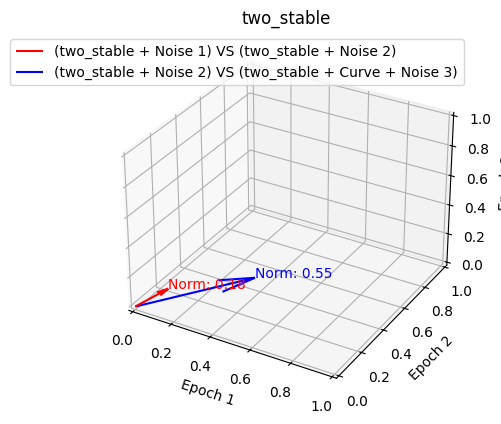

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Function to plot vectors in 3D
def plot_vectors(vector1, vector2, title, xlabel='Epoch 1', ylabel='Epoch 2', zlabel='Epoch 3'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.quiver(0, 0, 0, vector1[0], vector1[1], vector1[2], color='r', label='({} + Noise 1) VS ({} + Noise 2)'.format(title,title))
    ax.quiver(0, 0, 0, vector2[0], vector2[1], vector2[2], color='b', label='({} + Noise 2) VS ({} + Curve + Noise 3)'.format(title, title))

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    ax.text(vector1[0], vector1[1], vector1[2], f'Norm: {norm1:.2f}', color='r')
    ax.text(vector2[0], vector2[1], vector2[2], f'Norm: {norm2:.2f}', color='b')

    plt.title(title)
    ax.legend()
    plt.show()


plot_vectors(vectors_dsa_averaged['vector1'], vectors_dsa_averaged['vector2'], title='two_stable')

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 